## Generative Adversarial Network

Generative Adversarial Networks a.k.a GANs are emerging techniques that model high dimensional distribution of data. They achieve this by training a pair of networks, Generator and Discriminator, in competition with each other. As an analogy we can think of these models as an art forger and the other being an art expert. In GAN literature we term Generator as the forger and the duty of the generator is to produce fake images(forgeries) to deceive the art expert(Discriminator). The Discriminator which receives both the real images and fake images tries to distinguish between them and find the fake images. Both are trained simulataneously and are always in competition with each other. This competition between the Generator and Discriminator drives them to improve their models continuously. The models are trained until the generator produces the fake images that are indistinguishable with the real images.  <br>

In this setup, the generator do not have access to the synthetic images whereas the discriminator has access to both the real and fake images. While training the models, the supervisory signal to the discriminator is given by knowing whether the images came from a real image stack or generated image stack whereas the generator in the setup receives the error signal only from the discriminator.  

Let us define Discriminator D that takes image as input and produces a number **(0/1)** as output and a Generator G that takes random noise as input and outputs a fake image. In practise, G and D are trained alternately i.e., For a fixed generator G, the discriminator D is trained to classify the training data as real(output a value close to 1) or fake(output a value close to 0). In the next step we freeze the Discriminator assuming it as optimal and we the train the generator G to produce a image(fake) that outputs a value close to 1(real) when passed through the discriminator D. Thus, if the generator is perfectly trained then the discriminator D will be maximally confused by the images generated by G and predicts 0.5 for all the inputs. 



In this assignment, we will try to implement a Generative Adversarial Network on MNIST data and generate images that resemble the digits from the MNIST dataset.

To implement a GAN, we basically require 5 components:

- Real Dataset (real distribution)
- Low dimensional random noise that goes into the generator to produce fake images
- Generator that generates fake images
- Discriminator that acts as an expert to distinguish real and fake images.
- Training loop where the competition occurs and models better themselves


Let us implement each of the part and train the overall model:

In [266]:
## import packages

import torch
import random
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



## Checks for the availability of GPU 
if torch.cuda.is_available():
    print("working on gpu!")
    device = 'cuda'
else:
    print("No gpu! only cpu ;)")
    device = 'cpu'
    

working on gpu!


In [267]:
def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

In [268]:
import torchvision
import torchvision.transforms as transforms
import os

if not os.path.isdir('./data'):
    os.mkdir('./data')
root = './data/'

train_bs = 128

transform = transforms.Compose([transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))
        ])

training_data = torchvision.datasets.MNIST(root, train=True, transform=transform,download=True)
train_loader=torch.utils.data.DataLoader(dataset=training_data, batch_size=train_bs, shuffle=True, drop_last=True)


In GANs we input random noise through the generator to produce fake images which resemble the real distribution. Let us define a function which takes (batchsize, dimension) as input and returns a random noise of requested dimensions.

In [269]:

def noise(bs, dim):
    out = (torch.randn((bs, dim))/5).to(device)
#     out = (torch.FloatTensor(bs, dim).uniform_(-1.0, 1.0)).to(device)
    return out

Generator architecture:

- noise_dim -> 1024
- ReLU
- 1024 -> 1024
- ReLU
- 1024 -> 784
- TanH 
- clip image [-1, +1]

In [270]:

class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_size=784):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Linear(noise_dim, 1024)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
#         self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(1024, 1024)
        self.tanh = nn.Tanh()
        self.layer4 = nn.Linear(1024, out_size)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.leaky_relu(x)
#         x = self.layer2(x)
#         x = self.leaky_relu(x)
        x = self.layer3(x)
        x = self.leaky_relu(x)
        x = self.layer4(x)
        x = self.tanh(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x
        
        
        
        

Discriminator architecture:

- input_size->256
- LeakyReLU alpha=0.01
- 256e->256
- LeakyReLU alpha-=0.01
- 256->1

In [271]:
## Similar to the generator, we now define a discriminator which takes in a vector and output a value between 
## 0 and 1. We define the Discriminator as given in the above architecture.

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Linear(784, 128)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        
        self.layer2 = nn.Linear(128, 1)
        
#         self.layer3 = nn.Linear(256, 1)
#         self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.leaky_relu(x)
        x = self.layer2(x)
#         x = self.leaky_relu(x)
#         x = self.layer3(x)
        return x
        
        

In [272]:
bce_loss = nn.BCEWithLogitsLoss()

In [273]:
def DLoss(logits_real, logits_fake, targets_real, targets_fake):
    d1 = bce_loss(logits_real, targets_real)
    d2 = bce_loss(logits_fake, targets_fake)
    total_loss = d1 + d2
    return total_loss
    

In [274]:
def GLoss(logits_fake, targets_real):
    g_loss = bce_loss(logits_fake, targets_real)
    return g_loss

In [275]:
noise_dim = 96
epochs = 100

generator = Generator(noise_dim)
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

In [276]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))























  0%|          | 0/100 [00:00<?, ?it/s]

D Loss:  1.009412407875061
G Loss:  0.8710543513298035


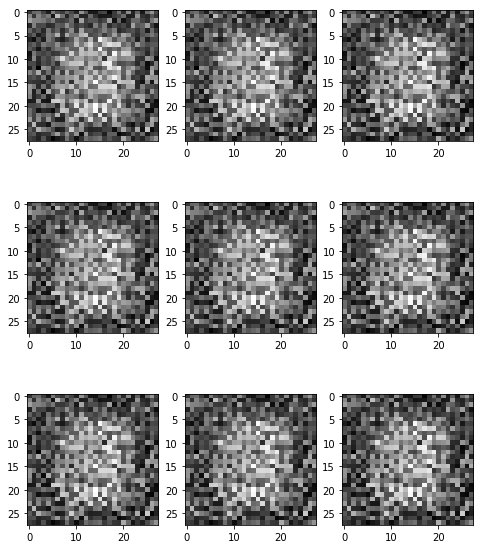























  1%|          | 1/100 [00:12<21:26, 12.99s/it]





















  2%|▏         | 2/100 [00:24<20:33, 12.58s/it]

D Loss:  0.8317400813102722
G Loss:  1.2328407764434814
D Loss:  0.7493182420730591
G Loss:  1.5783438682556152


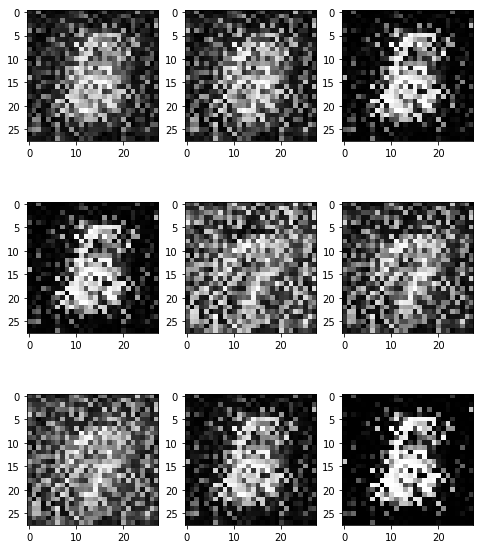























  3%|▎         | 3/100 [00:36<20:14, 12.52s/it]





















  4%|▍         | 4/100 [00:48<19:39, 12.29s/it]

D Loss:  0.735694169998169
G Loss:  1.8052729368209839
D Loss:  0.686664879322052
G Loss:  2.0829858779907227


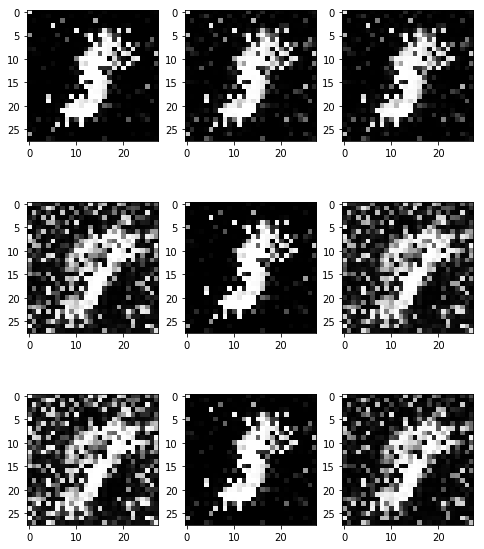























  5%|▌         | 5/100 [01:03<20:36, 13.02s/it]





















  6%|▌         | 6/100 [01:17<20:43, 13.23s/it]

D Loss:  0.6755279898643494
G Loss:  2.061992645263672
D Loss:  0.6670023202896118
G Loss:  1.945082426071167


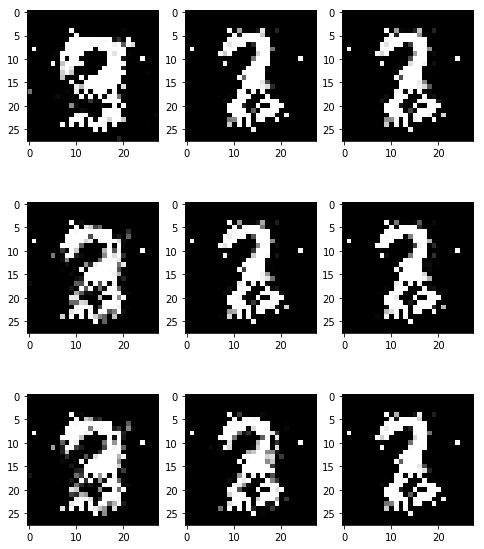























  7%|▋         | 7/100 [01:31<20:47, 13.42s/it]Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode= size=0x0 at 0x7F1E33137898>>
Traceback (most recent call last):
  File "/home/local/ASUAD/bnagaban/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/Image.py", line 614, in __del__
    if hasattr(self, "_close__fp"):
KeyboardInterrupt






















  8%|▊         | 8/100 [01:44<20:46, 13.55s/it]

D Loss:  0.6437524557113647
G Loss:  2.1222944259643555


In [ ]:
## Training loop

from tqdm import tqdm, trange

for epoch in trange(epochs, leave=False):
    for i, (images, _) in enumerate(train_loader):
        
#         targets_real = torch.ones((images.size(0), 1), requires_grad=False).to(device)
#         targets_fake = torch.zeros((images.size(0), 1), requires_grad=False).to(device)
        
        targets_real = (torch.FloatTensor(images.size(0), 1).uniform_(0.8, 1.0)).to(device)
        targets_fake = (torch.FloatTensor(images.size(0), 1).uniform_(0.0, 0.2)).to(device)
        
#         images = images + (torch.randn_like(images)*0.1)
        images = images.to(device)
        
        optimizer_D.zero_grad()
        real_logits = discriminator(preprocess_img(images))
        fake_images = generator(noise(train_bs, noise_dim)).detach()
        fake_logits = discriminator(fake_images)
        
        discriminator_loss = DLoss(real_logits, fake_logits, targets_real, targets_fake)
        discriminator_loss.backward()
        optimizer_D.step()
        
#         for i in range(5):
        optimizer_G.zero_grad()

        fake_images = generator(noise(train_bs, noise_dim))
        fake_logits = discriminator(fake_images)

        generator_loss = GLoss(fake_logits, targets_real)
        generator_loss.backward()
        optimizer_G.step()
    
    print("D Loss: ", discriminator_loss.item())
    print("G Loss: ", generator_loss.item())
          
    if epoch % 2 == 0:
        viz_batch = fake_images.data.cpu().numpy()
        fig = plt.figure(figsize=(8,10))
        for i in np.arange(1, 10):
            ax = fig.add_subplot(3, 3, i)
            img = viz_batch[i].squeeze()
            plt.imshow(img)
        plt.show()